# Experiment 2: Binary Classification using Naive Bayes and K-Nearest Neighbors

**Objective:**
To implement Naive Bayes and K-Nearest Neighbors (KNN) classifiers for a binary classification problem, evaluate them using multiple performance metrics, visualize model behavior, and analyze overfitting, underfitting, and bias-variance characteristics.

**Dataset:** Spambase Dataset (Binary Classification: Spam vs Non-Spam)

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_curve, auc, classification_report)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Ensure plot directories exist
os.makedirs('../plots/png', exist_ok=True)
os.makedirs('../plots/eps', exist_ok=True)

def save_plot(filename):
    plt.savefig(f'../plots/png/{filename}.png', dpi=600, bbox_inches='tight')
    plt.savefig(f'../plots/eps/{filename}.eps', dpi=600, bbox_inches='tight')
    print(f"✓ Saved: {filename}.png and {filename}.eps")

## 2. Load Dataset

In [2]:
# Load Spambase dataset from local CSV
print("Loading Spambase dataset from local CSV...")
csv_path = '../dataset/spambase/spambase_csv.csv'

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    # Rename target column for clarity (usually the last column)
    target_col = df.columns[-1]
    df.rename(columns={target_col: 'target'}, inplace=True)
else:
    # Fallback to OpenML if local file missing (safety net, though user confirmed local file)
    print("Local CSV not found, fetching from OpenML...")
    spambase = fetch_openml(name='spambase', version=1, as_frame=True)
    df = spambase.frame
    target_col = df.columns[-1]
    df.rename(columns={target_col: 'target'}, inplace=True)

print(f"Dataset Shape: {df.shape}")
print(df.head())

Loading Spambase dataset from local CSV...
Dataset Shape: (4601, 58)
   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_%3B  char_freq_%28  

## 3. Exploratory Data Analysis (EDA)

C:\Users\mehan\AppData\Local\Temp\ipykernel_32688\741583114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='viridis')


✓ Saved: class_distribution.png and class_distribution.eps


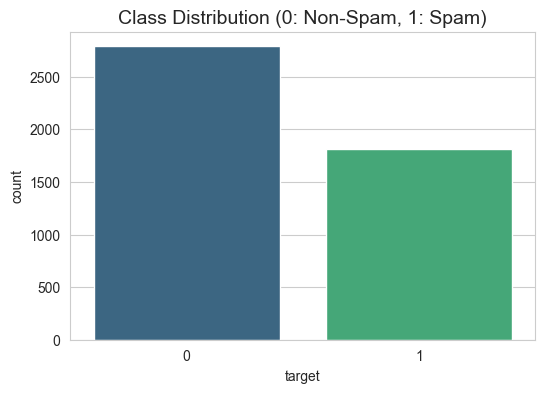

Class Counts:
target
0    0.605955
1    0.394045
Name: proportion, dtype: float64


In [3]:
# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Class Distribution (0: Non-Spam, 1: Spam)', fontsize=14)
save_plot('class_distribution')
plt.show()

print("Class Counts:")
print(df['target'].value_counts(normalize=True))

✓ Saved: feature_distribution.png and feature_distribution.eps


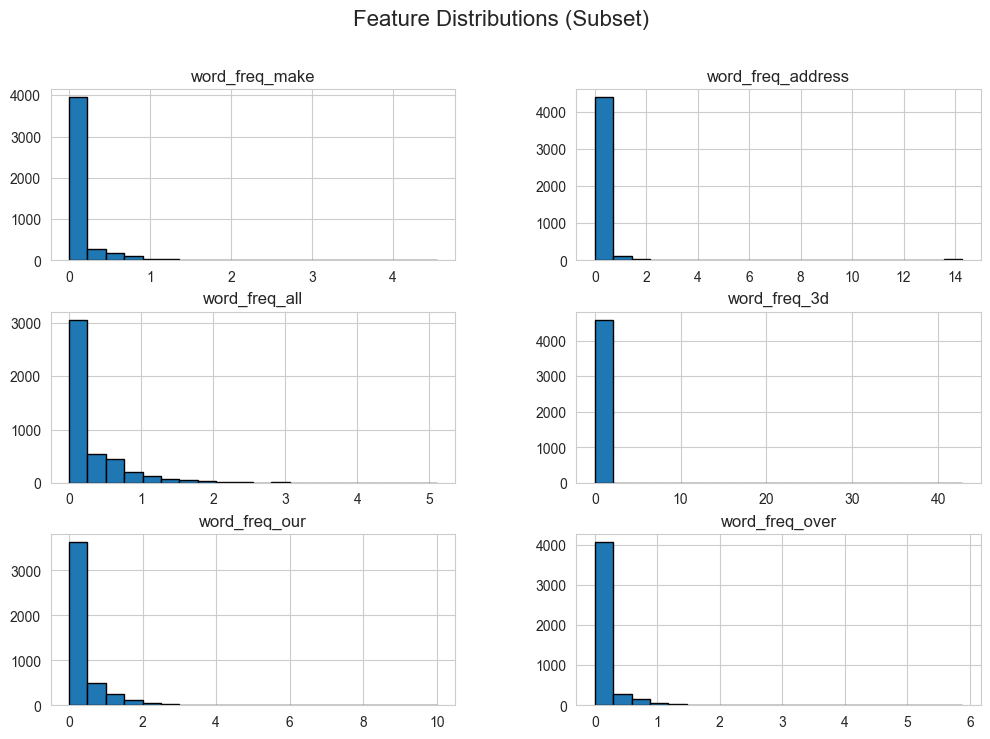

In [4]:
# Feature Distributions (Subset)
subset_cols = df.columns[:6]  # Visualize first 6 features
df[subset_cols].hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle('Feature Distributions (Subset)', fontsize=16)
save_plot('feature_distribution')
plt.show()

## 4. Preprocessing
- Check for missing values
- Scale features (MinMax for MultinomialNB, Standard for others)
- Split Data

In [5]:
# Check Missing
print("Missing Values:", df.isnull().sum().sum())

X = df.drop('target', axis=1)
y = df['target'].astype(int)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scaling
# MinMaxScaler is preferred for MultinomialNB (requires non-negative)
minmax_scaler = MinMaxScaler()
X_train_mm = minmax_scaler.fit_transform(X_train)
X_test_mm = minmax_scaler.transform(X_test)

# StandardScaler for GaussianNB and KNN (distance based)
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

Missing Values: 0


## 5. Naive Bayes Classifiers

In [6]:
nb_models = {
    'Gaussian NB': GaussianNB(),
    'Multinomial NB': MultinomialNB(),
    'Bernoulli NB': BernoulliNB()
}

nb_results = {}

for name, model in nb_models.items():
    start_time = time.time()
    # Use MinMax for Multinomial, Standard for others (optional, but Gaussian assumes normal dist)
    # For simplicity/comparability, Gaussian often works ok with scaled data, but theoretically raw is fine if Gaussian.
    # However, Multinomial MUST use non-negative.
    if name == 'Multinomial NB':
        model.fit(X_train_mm, y_train)
        train_time = time.time() - start_time
        start_pred = time.time()
        y_pred = model.predict(X_test_mm)
    else:
        # Using Standard scaled for others
        model.fit(X_train_std, y_train)
        train_time = time.time() - start_time
        start_pred = time.time()
        y_pred = model.predict(X_test_std)
        
    pred_time = time.time() - start_pred
    
    # Metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    nb_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Specificity': specificity,
        'Training Time (s)': train_time,
        'Prediction Time (s)': pred_time,
        'Model_Obj': model
    }

pd.DataFrame(nb_results).T

,Accuracy,Precision,Recall,F1 Score,Specificity,Training Time (s),Prediction Time (s),Model_Obj
Gaussian NB,0.819696,0.700136,0.948529,0.805621,0.735962,0.00325,0.000771,GaussianNB()
Multinomial NB,0.896452,0.929336,0.797794,0.858556,0.960573,0.001564,0.000242,MultinomialNB()
Bernoulli NB,0.902969,0.91,0.836397,0.871648,0.946237,0.005843,0.001541,BernoulliNB()


## 6. K-Nearest Neighbors (KNN)
### 6.1 Baseline KNN

In [7]:
knn_base = KNeighborsClassifier(n_neighbors=5)
knn_base.fit(X_train_std, y_train)
y_pred_knn = knn_base.predict(X_test_std)
print("Baseline KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

Baseline KNN Accuracy: 0.8993482983345402


### 6.2 Hyperparameter Tuning (Grid Search)

In [8]:
param_grid = {'n_neighbors': range(1, 31, 2), 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_std, y_train)

print("Best k (Grid):", grid_search.best_params_)
print("Best Accuracy (Grid):", grid_search.best_score_)

Best k (Grid): {'n_neighbors': 9, 'weights': 'distance'}
Best Accuracy (Grid): 0.9180124223602485


### 6.3 Randomized Search

In [9]:
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1)
random_search.fit(X_train_std, y_train)

print("Best k (Random):", random_search.best_params_)
print("Best Accuracy (Random):", random_search.best_score_)

Best k (Random): {'weights': 'distance', 'n_neighbors': 9}
Best Accuracy (Random): 0.9180124223602485


### 6.4 Accuracy vs k Plot

✓ Saved: knn_accuracy_vs_k.png and knn_accuracy_vs_k.eps


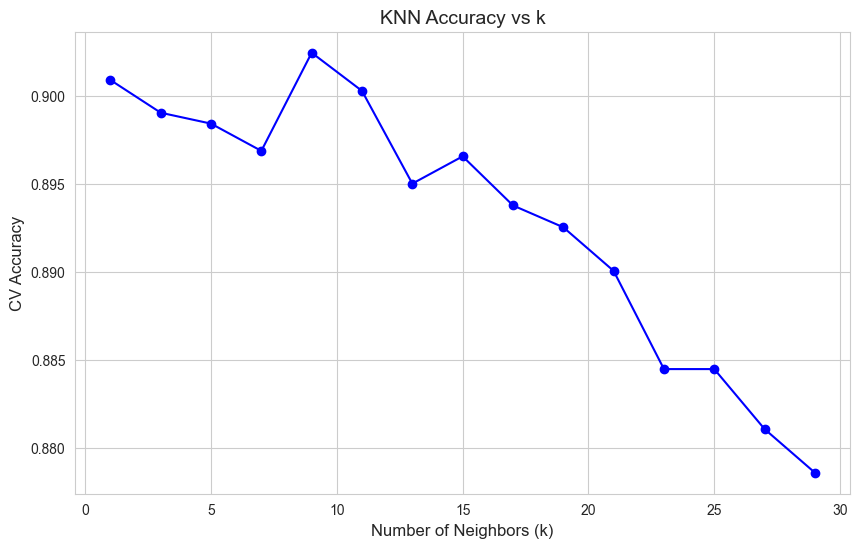

In [10]:
k_values = range(1, 31, 2)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_std, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('CV Accuracy', fontsize=12)
plt.title('KNN Accuracy vs k', fontsize=14)
save_plot('knn_accuracy_vs_k')
plt.show()

## 7. Neighbor Search Algorithms (KDTree vs BallTree)

In [11]:
best_k = grid_search.best_params_['n_neighbors']
algorithms = ['kd_tree', 'ball_tree']
algo_results = {}

for algo in algorithms:
    knn_algo = KNeighborsClassifier(n_neighbors=best_k, algorithm=algo)
    
    start_train = time.time()
    knn_algo.fit(X_train_std, y_train)
    train_time = time.time() - start_train
    
    start_pred = time.time()
    y_pred = knn_algo.predict(X_test_std)
    pred_time = time.time() - start_pred
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)

    algo_results[algo] = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Train Time', 'Pred Time'],
        'Value': [
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred),
            train_time,
            pred_time
        ]
    }
    # Store model for later viz
    if algo == 'kd_tree':
        knn_opt = knn_algo

print("Search Algorithm Comparison:")
for algo, res in algo_results.items():
    print(f"\n{algo.upper()}:")
    print(pd.DataFrame(res))

Search Algorithm Comparison:

KD_TREE:
       Metric     Value
0    Accuracy  0.907314
1   Precision  0.890977
2      Recall  0.871324
3    F1 Score  0.881041
4  Train Time  0.037768
5   Pred Time  0.366241

BALL_TREE:
       Metric     Value
0    Accuracy  0.907314
1   Precision  0.890977
2      Recall  0.871324
3    F1 Score  0.881041
4  Train Time  0.016670
5   Pred Time  0.321109


## 8. Visualizations & Analysis
### 8.1 Confusion Matrices

✓ Saved: confusion_matrices.png and confusion_matrices.eps


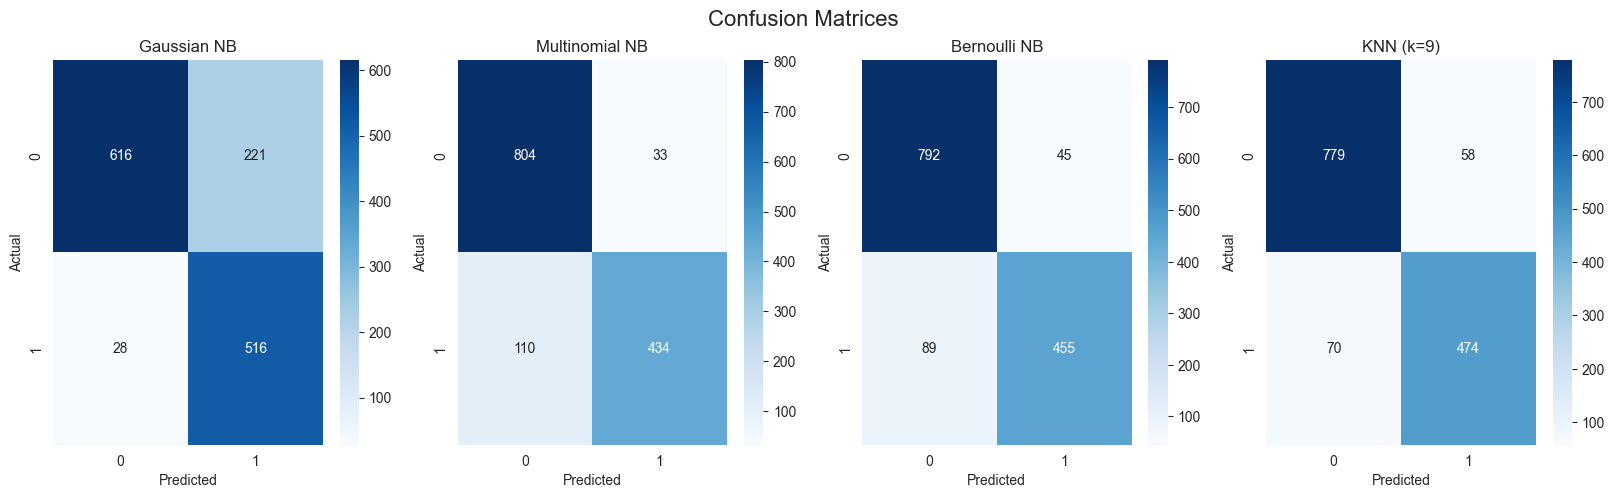

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
classifiers = [
    ('Gaussian NB', nb_results['Gaussian NB']['Model_Obj'], X_test_std),
    ('Multinomial NB', nb_results['Multinomial NB']['Model_Obj'], X_test_mm),
    ('Bernoulli NB', nb_results['Bernoulli NB']['Model_Obj'], X_test_std),
    (f'KNN (k={best_k})', knn_opt, X_test_std)
]

for ax, (name, model, X_val) in zip(axes, classifiers):
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrices', fontsize=16)
save_plot('confusion_matrices')
plt.show()

### 8.2 ROC Curves

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✓ Saved: roc_curves.png and roc_curves.eps


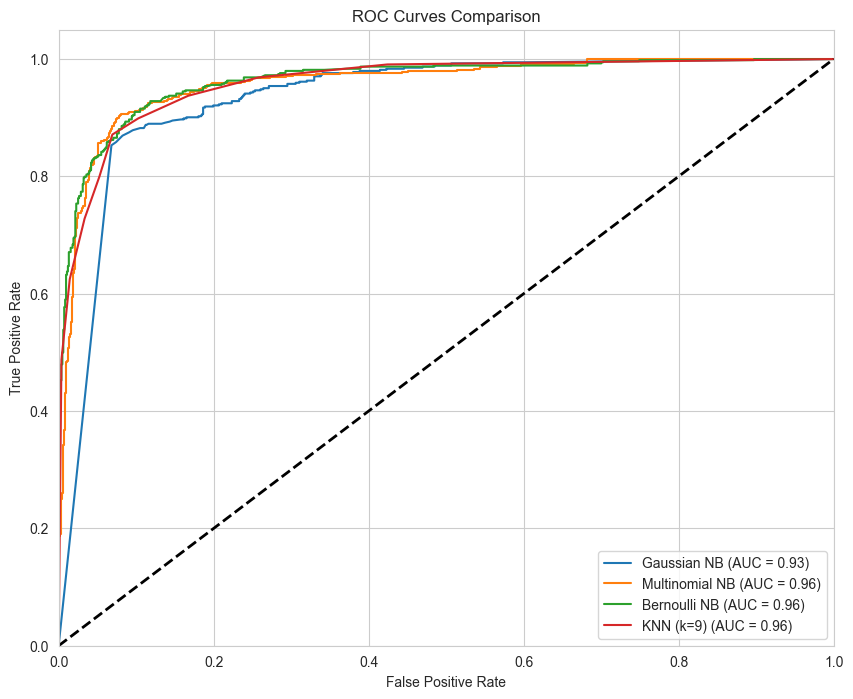

In [13]:
plt.figure(figsize=(10, 8))

for name, model, X_val in classifiers:
    y_prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
save_plot('roc_curves')
plt.show()

### 8.3 Bias-Variance Analysis (Learning Curves)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✓ Saved: learning_curve_nb.png and learning_curve_nb.eps


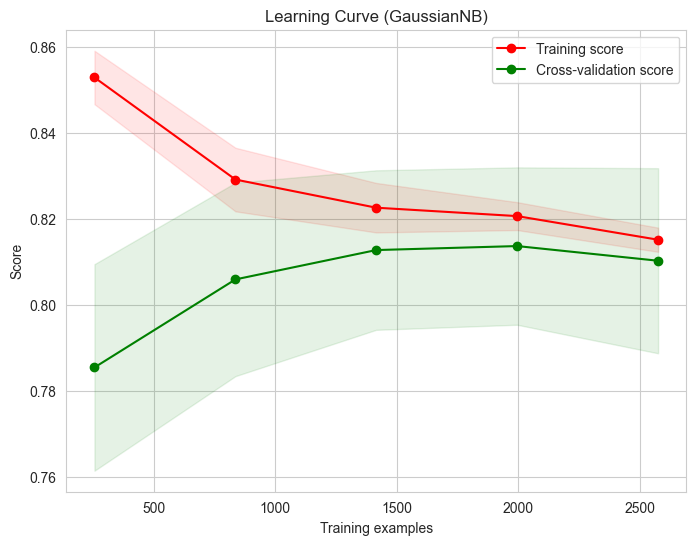

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✓ Saved: learning_curve_knn.png and learning_curve_knn.eps


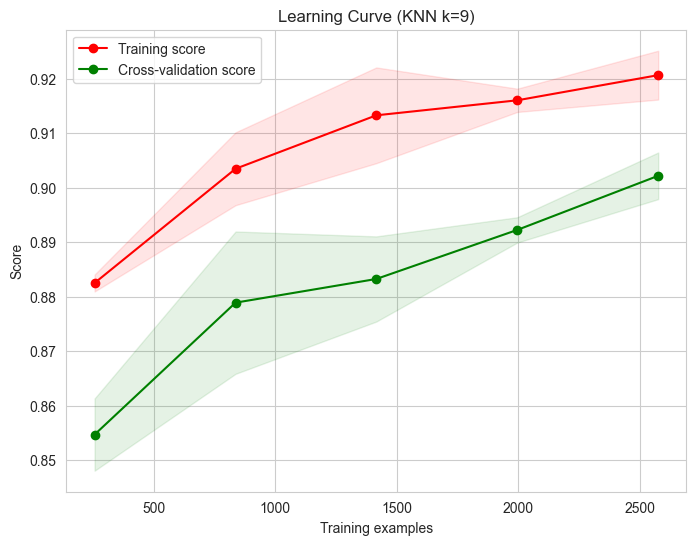

In [14]:
def plot_learning_curve(estimator, title, X, y, filename):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    save_plot(filename)
    plt.show()

# Learning Curve for GaussianNB
plot_learning_curve(GaussianNB(), "Learning Curve (GaussianNB)", X_train_std, y_train, 'learning_curve_nb')

# Learning Curve for Optimized KNN
plot_learning_curve(KNeighborsClassifier(n_neighbors=best_k), f"Learning Curve (KNN k={best_k})", X_train_std, y_train, 'learning_curve_knn')